In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py

import numpy as np

# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from himalaya.scoring import correlation_score
from scipy.stats import pearsonr

from util import plot, subject, stats
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [72]:
FG_MASK = get_brainmask()

cache = 'runmot24'
cache = 'nomot'
cache = 'trialmot9'

In [73]:
cachedir = f"results/cache/figurex-isc/{cache}/"
!mkdir -p $cachedir
cachedir

'results/cache/figurex-isc/trialmot9/'

# entire time series

In [74]:
def get_full_isc():
    iscs = []

    for subA in tqdm(SUBS_STRANGERS):

        dataA = subject.get_bold(subA, cache=cache)

        subB = subject.get_partner(subA)
        dataB = subject.get_bold(subB, cache=cache)

        iscs.append(correlation_score(dataA, dataB))

    sub_mbc = np.stack(iscs)
    
    return sub_mbc

In [75]:
sub_full_isc = get_full_isc()
sub_full_isc.shape

  0%|          | 0/58 [00:00<?, ?it/s]

100%|██████████| 58/58 [02:36<00:00,  2.69s/it]


(58, 81924)

In [76]:
# save
with h5py.File(f"{cachedir}/full_isc.hdf5", "w") as f:
    f.create_dataset(name="sub_full_isc", data=sub_full_isc)

In [ ]:
# read
# with h5py.File(f"{cachedir}/mbc.hdf5", "r") as f:
#     sub_mbc_comp = f["comp"][...]

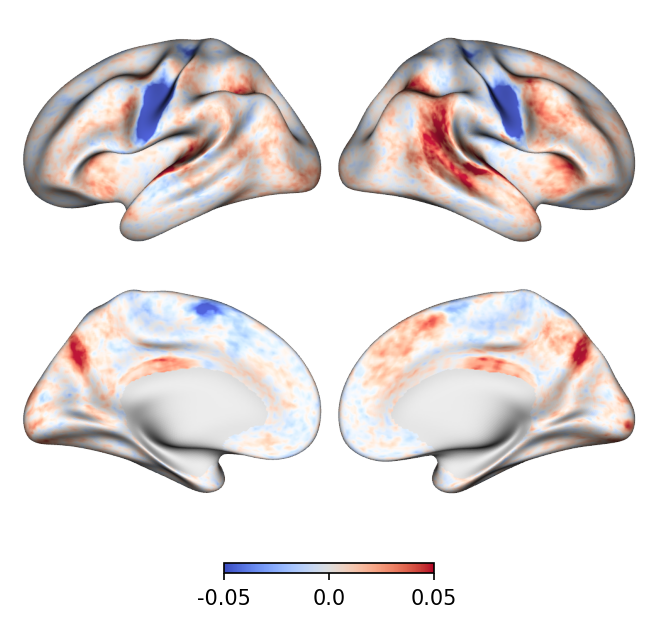

In [77]:
avg_isc = sub_full_isc.mean(0)
fig = plot.surface_plot(avg_isc, vmax=.05)

In [13]:
sigmask = stats.ttest_1samp(sub_full_isc, method='fdr_bh', alpha=0.01)
sigmask.sum()

14949

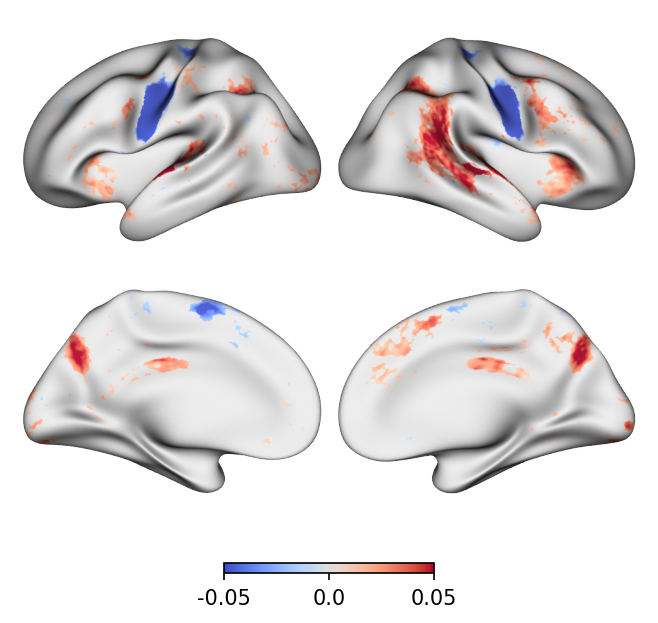

In [21]:
fig = plot.surface_plot(avg_isc, threshold=~sigmask, vmax=.05)

# prod-comp

In [23]:
def get_mode_isc():
    prod_iscs = []

    for subA in tqdm(SUBS_STRANGERS):

        dataA = subject.get_bold(subA, cache=cache)
        prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)

        subB = subject.get_partner(subA)
        dataB = subject.get_bold(subB, cache=cache)

        prod_mask = prod_boxcar.astype(bool)
        prod_iscs.append(correlation_score(dataA[prod_mask], dataB[prod_mask]))

    sub_prod_isc = np.stack(prod_iscs)
    
    return sub_prod_isc

In [79]:
sub_mode_isc = get_mode_isc()
sub_mode_isc.shape

100%|██████████| 58/58 [01:56<00:00,  2.01s/it]


(58, 81924)

In [80]:
# save
with h5py.File(f"{cachedir}/mode_isc.hdf5", "w") as f:
    f.create_dataset(name="sub_mode_isc", data=sub_mode_isc)

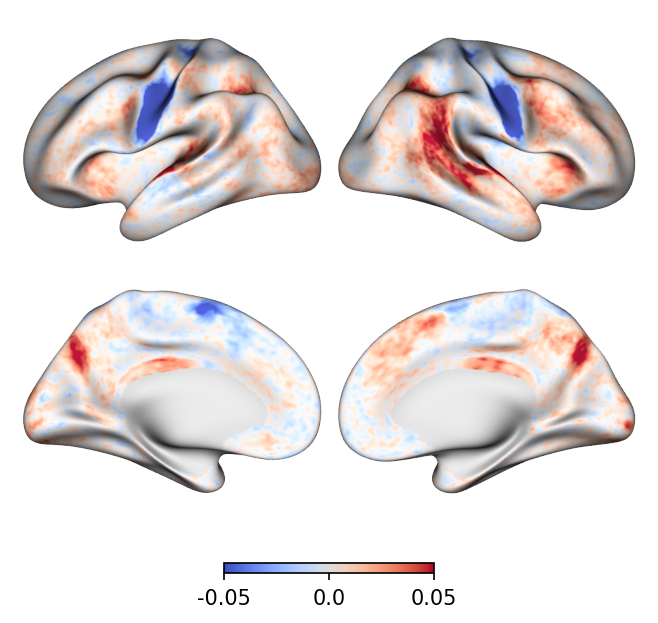

In [81]:
values = sub_mode_isc.mean(0)
fig = plot.surface_plot(values, vmax=.05)

# lagged entire time-series

In [34]:
lags = np.arange(-10, 11)
lags * 1.5

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5,  15. ])

In [35]:
sub_mbc_scores = []

for subA in tqdm(SUBS_STRANGERS):

    dataA = subject.get_bold(subA, cache=cache)

    subB = subject.get_partner(subA)
    dataB = subject.get_bold(subB, cache=cache)

    sub_scores = np.zeros((10, len(lags), 81924), dtype=np.float32)
    for k, t in enumerate(range(0, 1200, 120)):
        trial_slice = slice(t, t+120) 
        dataA_trial = dataA[trial_slice]
        dataB_trial = dataB[trial_slice]

        for i, lag in enumerate(lags):
            if lag < 0:
                trialA = dataA_trial[:lag]
                trialB = dataB_trial[-lag:]
            elif lag > 0:
                trialA = dataA_trial[lag:]
                trialB = dataB_trial[:-lag]
            else:
                trialA = dataA_trial
                trialB = dataB_trial

            sub_scores[k, i] = correlation_score(trialA, trialB)

    sub_mbc_scores.append(sub_scores)

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

100%|██████████| 58/58 [46:30<00:00, 48.11s/it]


(58, 10, 21, 81924)

In [36]:
# save
with h5py.File(f"{cachedir}/lagged_isc_entire.hdf5", "w") as f:
    f.create_dataset(name="sub_mbc_prod", data=sub_mbc_prod)

In [37]:
avg_isc_lags = sub_mbc_prod.mean((0,1))

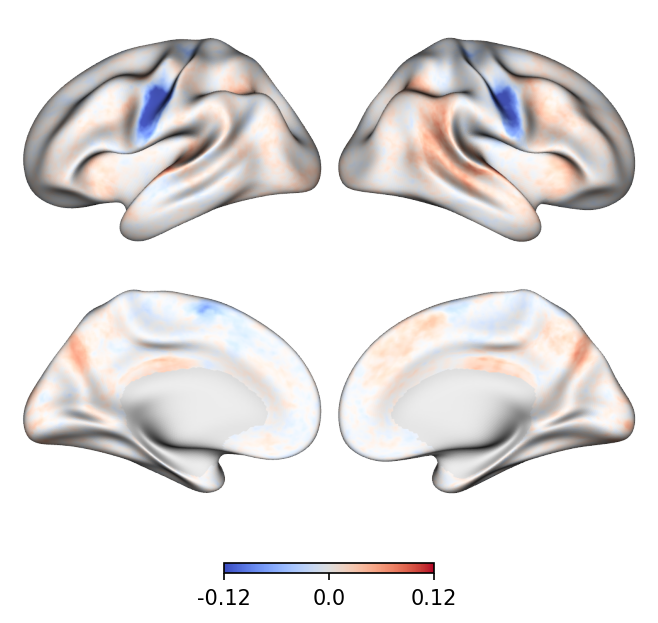

In [61]:
avg_isc_lag = avg_isc_lags[10] # 8:12 are best
fig = plot.surface_plot(avg_isc_lag)

In [48]:
catlas = Atlas.load("custom_glasser_group")
len(catlas)

22

In [49]:
parcel_lags = catlas.vox_to_parc(avg_isc_lags)
parcel_lags.shape

(21, 22)

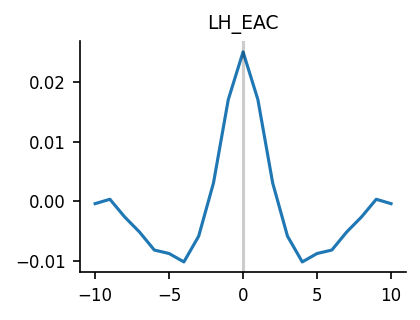

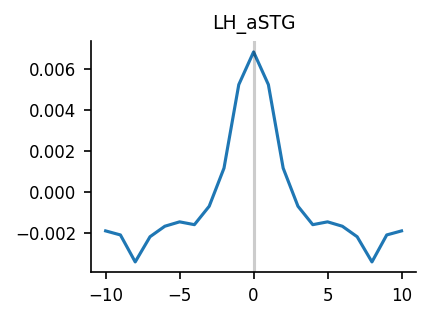

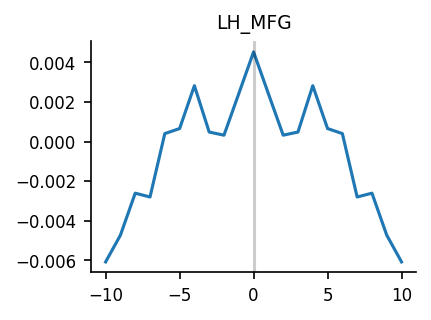

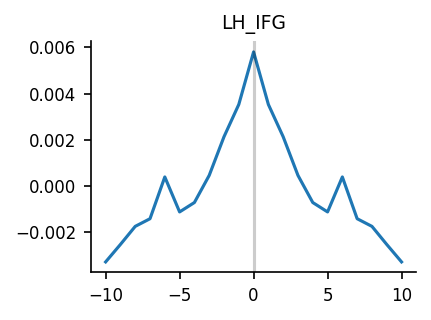

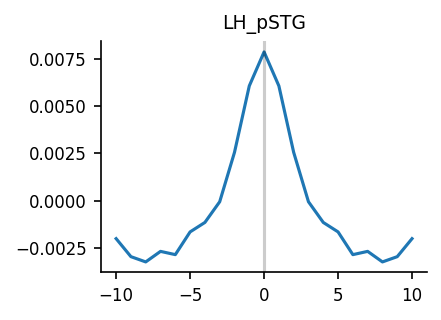

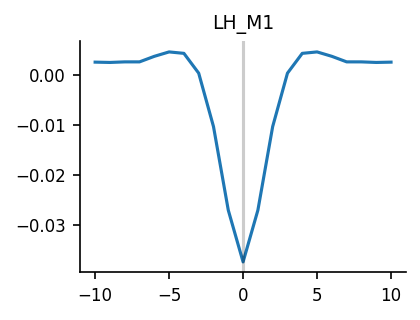

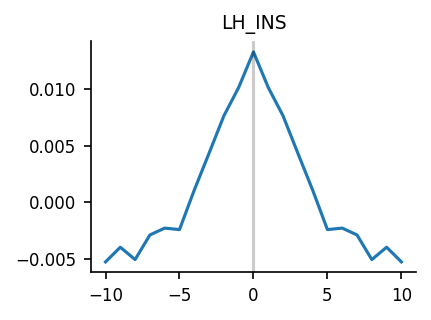

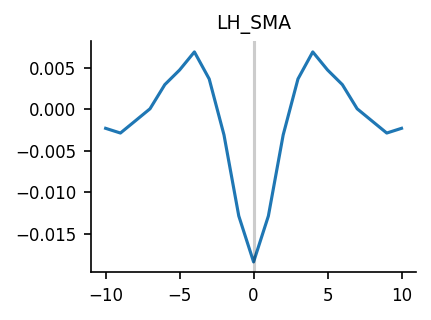

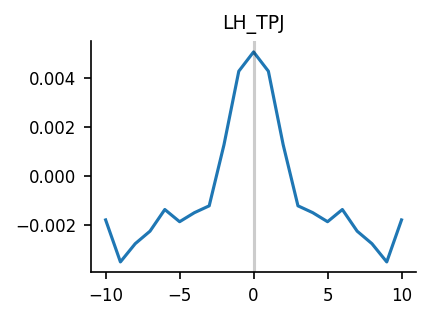

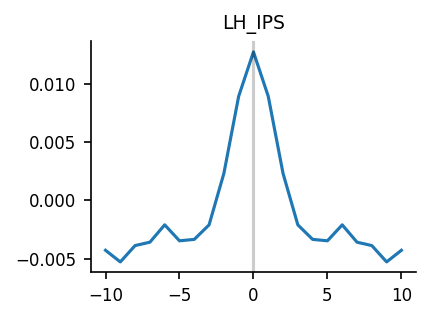

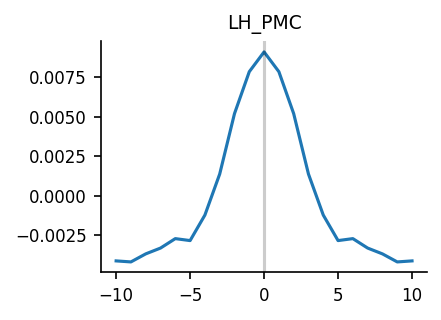

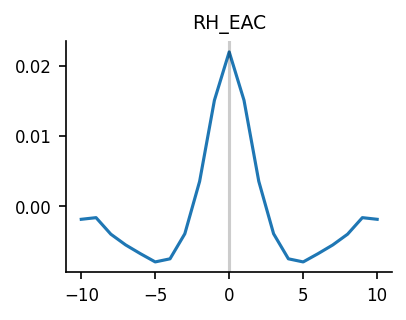

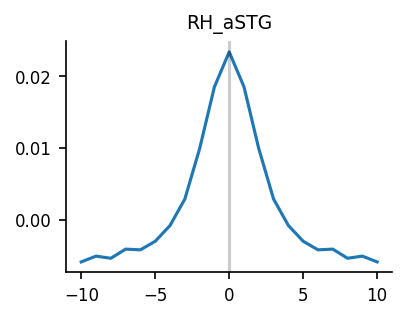

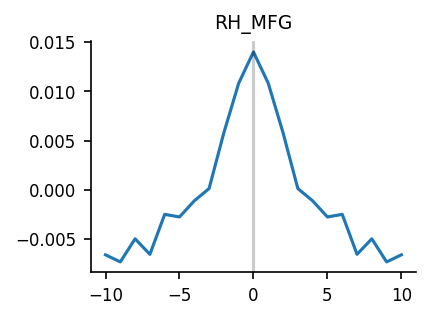

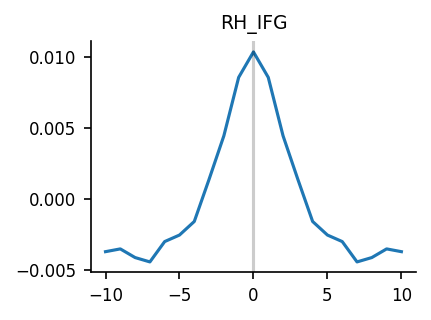

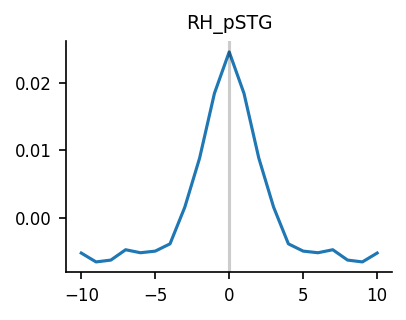

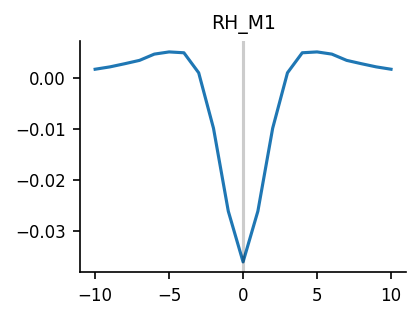

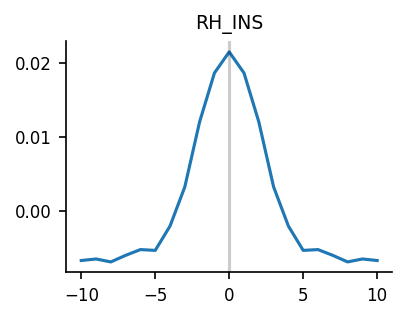

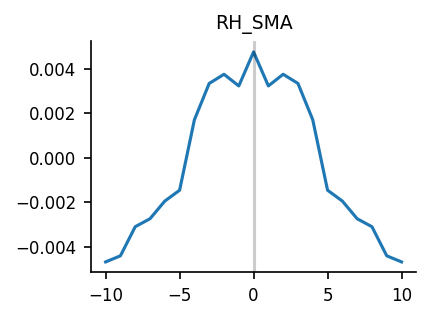

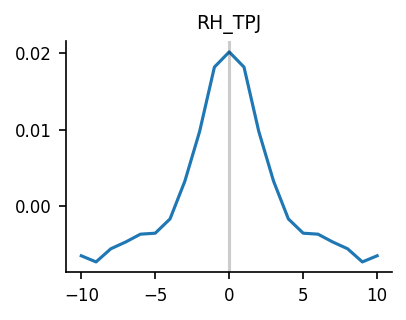

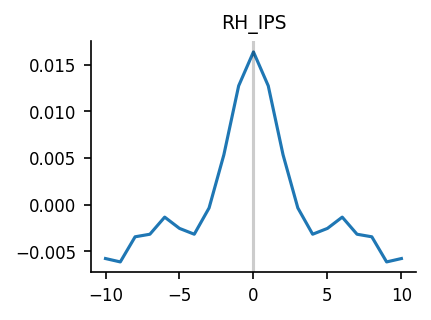

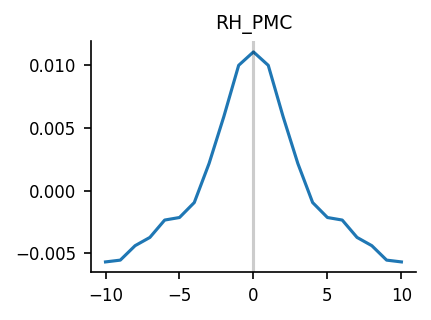

In [60]:
for i, label in enumerate(catlas.labels):
    plt.figure(figsize=(2.8, 2))
    plt.plot(lags, parcel_lags[:, i])
    plt.axvline(0, alpha=0.2, c='k')
    plt.title(label)
    plt.show()